In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys, os, os.path, time
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from TALNetModel import *
from util_in_multi_h5_unnorm import *
from util_out import *
from util_f1 import *
# from AudioResNet import resnet50
# from AST import ASTModel
from ast_models_original import ASTModel
%matplotlib inline
import subprocess
import pickle

import matplotlib.pyplot as plt
import h5py



In [2]:
curr_node = socket.gethostname().split('.')[0]
batcmd=f"squeue -u billyli | grep {curr_node}"
curr_slurm = subprocess.check_output(batcmd, shell=True, text=True)
slurm_id = curr_slurm.strip().split(' ')[0]
print(slurm_id)

8620457


In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

1

# VICTIM MODEL

In [4]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("--model_type", type=str, default='ast', help="the model used")
parser.add_argument("--dataset", type=str, default="audioset_s", help="the dataset used", choices=["audioset","audioset_s", "esc50", "speechcommands"])
parser.add_argument("--n_mels", type=int, default=128, help="number of mel bins")
parser.add_argument("--dataset-portion", type=str, default='full', help="balance set or full set")
parser.add_argument('--mean', default=-12.7508, type=float, help='normalizing mean')
parser.add_argument('--std', default=11.7584, type=float, help='normalizing std')

parser.add_argument("--exp-dir", type=str, default="", help="directory to dump experiments")
parser.add_argument('--lr', '--learning-rate', default="0.001", type=str, metavar='LR', help='initial learning rate')
parser.add_argument("--optim", type=str, default="adam", help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('-b', '--batch-size', default=12, type=int, metavar='N', help='mini-batch size')
parser.add_argument('-w', '--num-workers', default=32, type=int, metavar='NW', help='# of workers for dataloading (default: 32)')
parser.add_argument("--n-epochs", type=int, default=1, help="number of maximum training epochs")
# not used in the formal experiments
parser.add_argument("--lr_patience", type=int, default=2, help="how many epoch to wait to reduce lr if mAP doesn't improve")

parser.add_argument("--n-print-steps", type=int, default=100, help="number of steps to print statistics")

parser.add_argument('--freqm', help='frequency mask max length', type=int, default=0)
parser.add_argument('--timem', help='time mask max length', type=int, default=0)
parser.add_argument("--mixup", type=float, default=0, help="how many (0-1) samples need to be mixup during training")
parser.add_argument("--bal", type=str, default='bal', help="use balanced sampling or not")
# the stride used in patch spliting, e.g., for patch size 16*16, a stride of 16 means no overlapping, a stride of 10 means overlap of 6.
parser.add_argument("--fstride", type=int, default=8, help="soft split freq stride, overlap=patch_size-stride")
parser.add_argument("--tstride", type=int, default=8, help="soft split time stride, overlap=patch_size-stride")
parser.add_argument('--imagenet_pretrain', help='if use ImageNet pretrained audio spectrogram transformer model', type=bool, default='True')
parser.add_argument('--audioset_pretrain', help='if use ImageNet and audioset pretrained audio spectrogram transformer model', type=bool, default='False')

parser.add_argument('--embedding_size', type = int, default = 1024) # this is the embedding size after a pooling layer
                                                                    # after a non-pooling layer, the embeddings size will be twice this much
parser.add_argument('--n_conv_layers', type = int, default = 10)
parser.add_argument('--n_trans_layers', type = int, default = 2)
parser.add_argument('--kernel_size', type = str, default = '3')     # 'n' or 'nxm'
parser.add_argument('--n_pool_layers', type = int, default = 5)     # the pooling layers will be inserted uniformly into the conv layers
                                                                    # the should be at least 2 and at most 6 pooling layers
                                                                    # the first two pooling layers will have stride (2,2); later ones will have stride (1,2)
parser.add_argument('--batch_norm', type = bool, default = True)
parser.add_argument('--dropout', type = float, default = 0.0)
parser.add_argument('--pooling', type = str, default = 'att', choices = ['max', 'ave', 'lin', 'exp', 'att', 'h-att', 'all'])
parser.add_argument('--continue_from_ckpt', type = str, default = None)
parser.add_argument('--addpos', type = bool, default = True)
parser.add_argument('--transformer_dropout', type = float, default = 0.75)
parser.add_argument('--suffix', type=str, default='')


_StoreAction(option_strings=['--suffix'], dest='suffix', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help=None, metavar=None)

### TALtrans 64x400 best model

In [5]:
args = parser.parse_args(args=['--model_type=TALtrans','--dataset=audioset_s','--n_mels=64', '--mean=-29.686901','--std=40.898224',
                               '--lr=4e-4','--batch-size=448','--n-epochs=10',
                               '--freqm=12','--timem=60','--mixup=0.3',
                               '--transformer_dropout=0.75','--addpos=True','--pooling=att',
                               '--imagenet_pretrain=True','--suffix=new_model_dev_41.1'])
if 'x' not in args.kernel_size:
    args.kernel_size = args.kernel_size + 'x' + args.kernel_size
args.kernel_size = tuple(int(x) for x in args.kernel_size.split('x'))
args.target_length=400
exp_id = f"{args.model_type}-{args.dataset}-{args.dataset_portion}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
-fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}\
-conv{args.n_conv_layers}-pool{args.n_pool_layers}-trans{args.n_trans_layers}-{args.suffix}"
print(exp_id)
WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.7.pth')

TALtrans-audioset_s-full-pTrue-b448-lr4e-4-fm12-tm60-mix0.3-m-29.686901-std40.898224-epoch10-conv10-pool5-trans2-new_model_dev_41.1


### AST 128x1024 best model

In [6]:
# args = parser.parse_args(args=['--model_type=AST','--dataset=audioset','--n_mels=128', '--mean=-3.6788461','--std=4.3739743',
#                                '--lr=1e-5','--batch-size=20','--n-epochs=10','--fstride=10','--tstride=10',
#                                '--freqm=36','--timem=192','--mixup=0.3',
#                                '--imagenet_pretrain=True','--suffix=ast_challenge-43.0'])
# args.target_length=1024
# exp_id = f"{args.dataset}-{args.dataset_portion}-f{args.fstride}-t{args.tstride}-p{args.imagenet_pretrain}-b{args.batch_size}-lr{args.lr}\
# -fm{args.freqm}-tm{args.timem}-mix{args.mixup}-m{args.mean}-std{args.std}-epoch{args.n_epochs}-{args.suffix}"
# print(exp_id)
# WORKSPACE = '/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp'
# MODEL_FILE = os.path.join(WORKSPACE, exp_id, 'models', 'audio_model.3.pth')

In [7]:
print(MODEL_FILE)

/jet/home/billyli/data_folder/AllaboutAudioSet_hack/egs/audioset/exp/TALtrans-audioset_s-full-pTrue-b448-lr4e-4-fm12-tm60-mix0.3-m-29.686901-std40.898224-epoch10-conv10-pool5-trans2-new_model_dev_41.1/models/audio_model.7.pth


In [8]:
args

Namespace(addpos=True, audioset_pretrain=True, bal='bal', batch_norm=True, batch_size=448, continue_from_ckpt=None, dataset='audioset_s', dataset_portion='full', dropout=0.0, embedding_size=1024, exp_dir='', freqm=12, fstride=8, imagenet_pretrain=True, kernel_size=(3, 3), lr='4e-4', lr_patience=2, mean=-29.686901, mixup=0.3, model_type='TALtrans', n_conv_layers=10, n_epochs=10, n_mels=64, n_pool_layers=5, n_print_steps=100, n_trans_layers=2, num_workers=32, optim='adam', pooling='att', std=40.898224, suffix='new_model_dev_41.1', target_length=400, timem=60, transformer_dropout=0.75, tstride=8)

In [9]:
# Load model
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = Net(args).cuda()
elif args.model_type == 'TALtrans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, fstride=args.fstride, tstride=args.tstride, input_fdim=args.n_mels, input_tdim=args.target_length, imagenet_pretrain=args.imagenet_pretrain, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/TALNetModel.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.conv.weight)
/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/TALNetModel.py:493: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc_prob.weight); nn.init.constant(self.fc_prob.bias, 0)
/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/TALNetModel.py:493: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.xavier_uniform(self.fc_prob.weight); nn.init.constant(self.fc_prob.bias, 0)
/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/AudioSetDoneRight/TALNetModel.py:495: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc_att.w

In [10]:
optimizer = Adam(model.parameters())


In [11]:
prev_ckpt = torch.load(MODEL_FILE)
# start_ckpt = prev_ckpt['epoch']
# scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
temp = {}
for key, val in prev_ckpt.items():
    key = key.replace('module.','')
    temp[key] = val
model.load_state_dict(temp)
# optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

TransformerEncoder(
  (conv): ModuleList(
    (0): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

In [12]:
N_CLASSES = 527
N_WORKERS = 6
local = f"/local/slurm-{slurm_id}/local/audio"
if args.dataset == 'audioset_s':
    hf_val_eval_path = os.path.join(local, 'data_64_400_again.h5')
elif args.dataset == 'audioset':
    hf_val_eval_path = os.path.join(local, 'data_128_1024_again.h5')
# hf_val_eval_path = os.path.join(local, 'data_128_1024_strong_cleaned.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [13]:
gas_eval_x1.shape, gas_eval_y.shape, mu_val, sigma_val

((20123, 400, 64), (20123, 527), -29.686901, 40.898224)

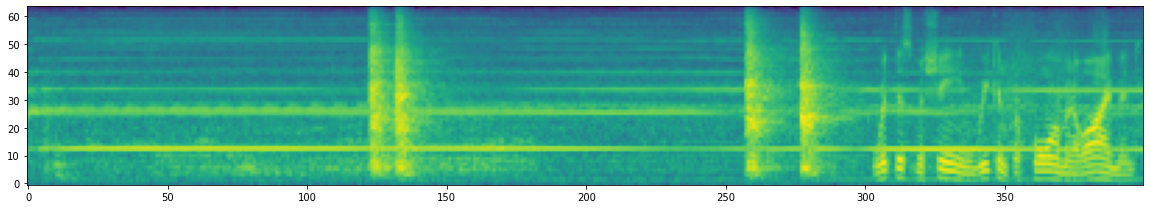

In [14]:
plt.figure(figsize = (20,10))
plt.imshow(gas_eval_x1[1].T, origin='lower')

# Inference

In [15]:
result = []
batch_size =100
x = gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]


total num of batches during testing 202


In [16]:
print(result[0].shape)

(20123, 527)


In [17]:
gas_eval_global_prob_multi = result[0]
print(gas_eval_global_prob_multi.shape)

(20123, 527)


In [20]:
import numpy as np
from scipy import stats
from sklearn import metrics
import torch

def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime

def calculate_stats(output, target):
    """Calculate statistics including mAP, AUC, etc.
    Args:
      output: 2d array, (samples_num, classes_num)
      target: 2d array, (samples_num, classes_num)
    Returns:
      stats: list of statistic of each class.
    """

    classes_num = target.shape[-1]
    stats = []

    # Accuracy, only used for single-label classification such as esc-50, not for multiple label one such as AudioSet
    acc = metrics.accuracy_score(np.argmax(target, 1), np.argmax(output, 1))

    # Class-wise statistics
    for k in range(classes_num):

        # Average precision
        avg_precision = metrics.average_precision_score(
            target[:, k], output[:, k], average=None)

        # AUC
        auc = metrics.roc_auc_score(target[:, k], output[:, k], average=None)

        # Precisions, recalls
        (precisions, recalls, thresholds) = metrics.precision_recall_curve(
            target[:, k], output[:, k])

        # FPR, TPR
        (fpr, tpr, thresholds) = metrics.roc_curve(target[:, k], output[:, k])

        save_every_steps = 1000     # Sample statistics to reduce size
        dict = {'precisions': precisions[0::save_every_steps],
                'recalls': recalls[0::save_every_steps],
                'AP': avg_precision,
                'fpr': fpr[0::save_every_steps],
                'fnr': 1. - tpr[0::save_every_steps],
                'auc': auc,
                # note acc is not class-wise, this is just to keep consistent with other metrics
                'acc': acc
                }
        stats.append(dict)

    return stats

In [21]:
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
statis = calculate_stats(gas_eval_global_prob_multi, gas_eval_y) 

In [23]:
print(gas_eval_global_prob_multi,'max:', np.max(gas_eval_global_prob_multi), 'min: ', np.min(gas_eval_global_prob_multi))

[[1.1179241e-03 6.1819825e-05 5.9610809e-04 ... 3.9053197e-05
  2.0023814e-05 1.5902086e-05]
 [4.2456207e-01 4.2433938e-05 2.4824860e-06 ... 5.1568171e-05
  6.6610155e-05 1.2053022e-06]
 [1.4788178e-03 6.4048846e-04 2.6053874e-04 ... 2.2949105e-04
  2.6540931e-05 2.3312700e-06]
 ...
 [1.4195487e-01 1.5079214e-03 3.1655568e-03 ... 1.5285425e-03
  1.5582494e-03 1.9189665e-05]
 [7.2730728e-04 5.2557052e-06 8.0890350e-06 ... 4.3309769e-06
  4.0624916e-05 4.8013067e-07]
 [1.0667867e-04 4.5214947e-05 1.3418108e-05 ... 5.8993897e-05
  2.2396036e-04 7.4585457e-04]] max: 0.9997545 min:  9.999994e-08


In [22]:
mAP = np.mean([stat['AP'] for stat in statis])
mAUC = np.mean([stat['auc'] for stat in statis])
dprime_val = d_prime(mAUC)
print(mAP)
print(mAUC)
print(dprime_val)

0.41149856315118066
0.9705852038793852
2.6721065647895337


In [18]:
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------


In [19]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.4114985631511802 0.9705852038793857 2.6721065647895457
 Average | 0.411 | 0.971 | 2.672 
---------+-------+-------+-------
       0 | 0.789 | 0.932 | 2.107 
       1 | 0.069 | 0.825 | 1.321 
       2 | 0.094 | 0.941 | 2.216 
       3 | 0.400 | 0.968 | 2.623 
       4 | 0.221 | 0.970 | 2.661 
       5 | 0.083 | 0.947 | 2.285 
       6 | 0.530 | 0.996 | 3.793 
       7 | 0.407 | 0.986 | 3.115 
       8 | 0.174 | 0.963 | 2.520 
       9 | 0.103 | 0.938 | 2.171 
      10 | 0.192 | 0.973 | 2.731 
      11 | 0.235 | 0.985 | 3.087 
      12 | 0.806 | 0.999 | 4.330 
      13 | 0.506 | 0.996 | 3.703 
      14 | 0.266 | 0.984 | 3.032 
      15 | 0.824 | 0.999 | 4.480 
      16 | 0.424 | 0.982 | 2.977 
      17 | 0.643 | 0.995 | 3.676 
      18 | 0.251 | 0.982 | 2.970 
      19 | 0.264 | 0.980 | 2.893 
      20 | 0.331 | 0.991 | 3.367 
      21 | 0.225 | 0.981 | 2.933 
      22 | 0.510 | 0.988 | 3.185 
      23 | 0.534 | 0.989 | 3.234 
      24 | 0.262 | 0.978 | 2.847 
      25 | 0.151 | 0.939 

# Occlusion

In [20]:
gas_eval_x1_origin = gas_eval_x1

In [21]:
min_val = numpy.min(gas_eval_x1)
max_val = numpy.max(gas_eval_x1)
mean_val = numpy.mean(gas_eval_x1)
std_val = numpy.std(gas_eval_x1)
print(min_val, max_val, mean_val, std_val)

-2.0821576 1.3378971 -0.11577156 0.5719845


In [22]:
gas_eval_x1.shape

(20123, 400, 64)

### Occ 4s

In [26]:
new_gas_eval = []
time_frame = 400
step = 80
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

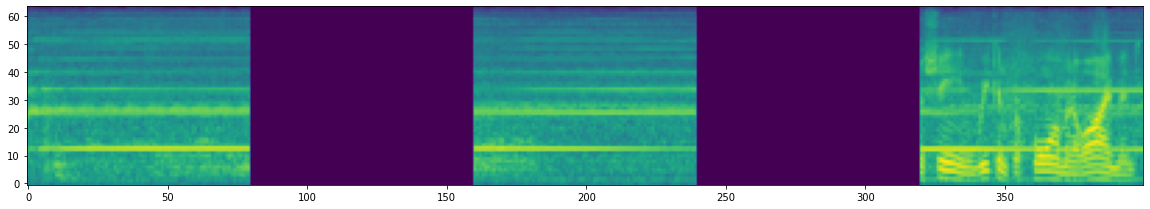

In [27]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [28]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3491268105567951 0.9562933838467274 2.4171789880282195
 Average | 0.349 | 0.956 | 2.417 
---------+-------+-------+-------
       0 | 0.743 | 0.912 | 1.914 
       1 | 0.063 | 0.826 | 1.327 
       2 | 0.088 | 0.932 | 2.105 
       3 | 0.384 | 0.960 | 2.470 
       4 | 0.182 | 0.962 | 2.509 
       5 | 0.062 | 0.939 | 2.184 
       6 | 0.387 | 0.992 | 3.392 
       7 | 0.290 | 0.981 | 2.921 
       8 | 0.124 | 0.948 | 2.302 
       9 | 0.094 | 0.937 | 2.169 
      10 | 0.158 | 0.958 | 2.451 
      11 | 0.174 | 0.976 | 2.787 
      12 | 0.791 | 0.999 | 4.207 
      13 | 0.431 | 0.994 | 3.529 
      14 | 0.260 | 0.969 | 2.641 
      15 | 0.748 | 0.997 | 3.861 
      16 | 0.364 | 0.978 | 2.856 
      17 | 0.555 | 0.993 | 3.497 
      18 | 0.182 | 0.966 | 2.580 
      19 | 0.173 | 0.968 | 2.621 
      20 | 0.226 | 0.985 | 3.052 
      21 | 0.165 | 0

<h>First 5s</h>

In [29]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[:200]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

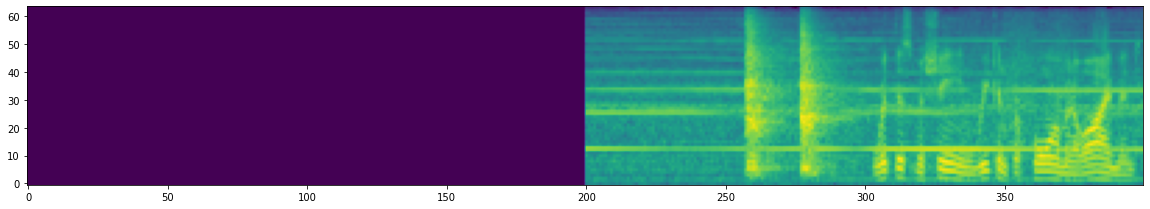

In [30]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [31]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.31527174609283143 0.9390277759481799 2.187312268319399
 Average | 0.315 | 0.939 | 2.187 
---------+-------+-------+-------
       0 | 0.687 | 0.872 | 1.607 
       1 | 0.052 | 0.812 | 1.252 
       2 | 0.084 | 0.920 | 1.988 
       3 | 0.341 | 0.946 | 2.274 
       4 | 0.126 | 0.944 | 2.253 
       5 | 0.040 | 0.922 | 2.009 
       6 | 0.337 | 0.980 | 2.904 
       7 | 0.222 | 0.983 | 2.985 
       8 | 0.122 | 0.927 | 2.056 
       9 | 0.083 | 0.929 | 2.073 
      10 | 0.091 | 0.945 | 2.260 
      11 | 0.117 | 0.944 | 2.254 
      12 | 0.705 | 0.994 | 3.572 
      13 | 0.336 | 0.990 | 3.279 
      14 | 0.209 | 0.963 | 2.521 
      15 | 0.645 | 0.950 | 2.326 
      16 | 0.301 | 0.960 | 2.470 
      17 | 0.409 | 0.985 | 3.075 
      18 | 0.133 | 0.947 | 2.292 
      19 | 0.178 | 0.950 | 2.328 
      20 | 0.289 | 0.974 | 2.741 
      21 | 0.147 | 0

<h>mid 5s</h>

In [29]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

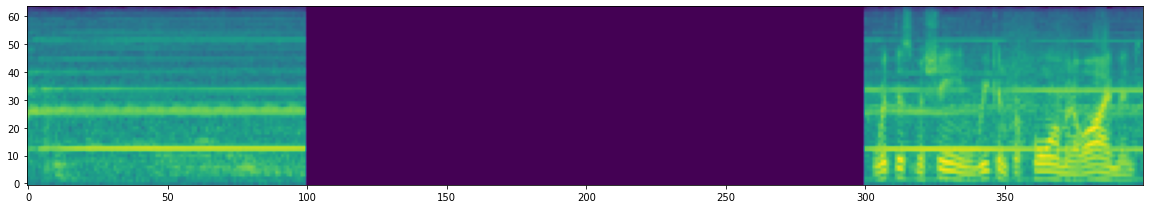

In [30]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [31]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.33136189297701474 0.9489967963699049 2.3125268821798635
 Average | 0.331 | 0.949 | 2.313 
---------+-------+-------+-------
       0 | 0.716 | 0.896 | 1.777 
       1 | 0.055 | 0.826 | 1.326 
       2 | 0.097 | 0.937 | 2.162 
       3 | 0.334 | 0.943 | 2.235 
       4 | 0.191 | 0.957 | 2.434 
       5 | 0.069 | 0.927 | 2.052 
       6 | 0.311 | 0.978 | 2.850 
       7 | 0.324 | 0.972 | 2.710 
       8 | 0.110 | 0.942 | 2.220 
       9 | 0.076 | 0.922 | 2.002 
      10 | 0.144 | 0.949 | 2.310 
      11 | 0.143 | 0.964 | 2.536 
      12 | 0.733 | 0.998 | 4.148 
      13 | 0.406 | 0.991 | 3.325 
      14 | 0.194 | 0.953 | 2.374 
      15 | 0.765 | 0.981 | 2.938 
      16 | 0.336 | 0.972 | 2.700 
      17 | 0.446 | 0.987 | 3.164 
      18 | 0.213 | 0.955 | 2.401 
      19 | 0.175 | 0.950 | 2.332 
      20 | 0.268 | 0.983 | 2.995 
      21 | 0.164 | 

<h>mid 5s</h>

In [32]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[200:400]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

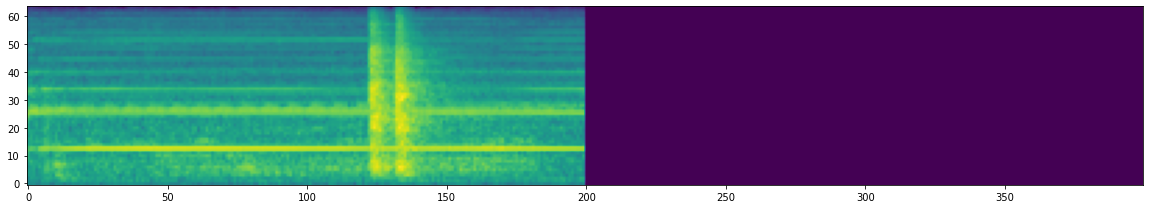

In [33]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [34]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.32270224058493 0.9397730040430033 2.196091017682446
 Average | 0.323 | 0.940 | 2.196 
---------+-------+-------+-------
       0 | 0.702 | 0.877 | 1.641 
       1 | 0.029 | 0.812 | 1.251 
       2 | 0.061 | 0.907 | 1.871 
       3 | 0.316 | 0.940 | 2.201 
       4 | 0.138 | 0.938 | 2.174 
       5 | 0.045 | 0.911 | 1.906 
       6 | 0.387 | 0.970 | 2.662 
       7 | 0.261 | 0.976 | 2.805 
       8 | 0.126 | 0.931 | 2.093 
       9 | 0.079 | 0.911 | 1.907 
      10 | 0.137 | 0.956 | 2.419 
      11 | 0.187 | 0.956 | 2.409 
      12 | 0.731 | 0.998 | 4.090 
      13 | 0.270 | 0.970 | 2.667 
      14 | 0.177 | 0.945 | 2.262 
      15 | 0.795 | 0.977 | 2.831 
      16 | 0.355 | 0.961 | 2.499 
      17 | 0.563 | 0.964 | 2.543 
      18 | 0.174 | 0.949 | 2.315 
      19 | 0.193 | 0.939 | 2.183 
      20 | 0.322 | 0.955 | 2.391 
      21 | 0.171 | 0.95

<h>Every 1s</h1>

In [35]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

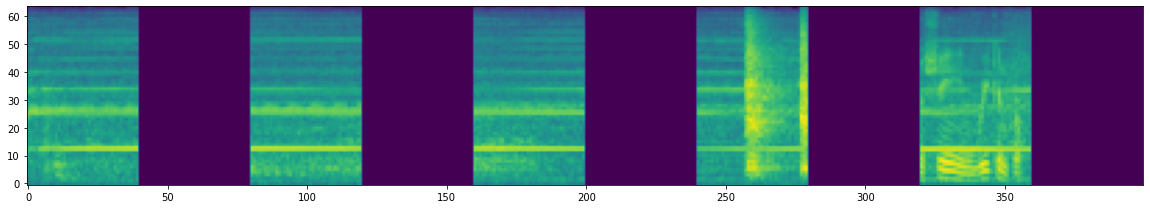

In [36]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [37]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.2916435929499431 0.941287908970971 2.214202078569477
 Average | 0.292 | 0.941 | 2.214 
---------+-------+-------+-------
       0 | 0.703 | 0.894 | 1.766 
       1 | 0.042 | 0.818 | 1.285 
       2 | 0.062 | 0.927 | 2.058 
       3 | 0.321 | 0.953 | 2.363 
       4 | 0.152 | 0.950 | 2.332 
       5 | 0.056 | 0.934 | 2.136 
       6 | 0.335 | 0.979 | 2.881 
       7 | 0.279 | 0.979 | 2.876 
       8 | 0.123 | 0.929 | 2.072 
       9 | 0.050 | 0.909 | 1.887 
      10 | 0.122 | 0.950 | 2.325 
      11 | 0.106 | 0.935 | 2.143 
      12 | 0.692 | 0.998 | 4.066 
      13 | 0.218 | 0.988 | 3.175 
      14 | 0.190 | 0.957 | 2.431 
      15 | 0.737 | 0.997 | 3.963 
      16 | 0.357 | 0.975 | 2.769 
      17 | 0.534 | 0.989 | 3.229 
      18 | 0.130 | 0.955 | 2.404 
      19 | 0.178 | 0.949 | 2.315 
      20 | 0.285 | 0.969 | 2.646 
      21 | 0.119 | 0.9

<h>Every 0.5s</h1>

In [38]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

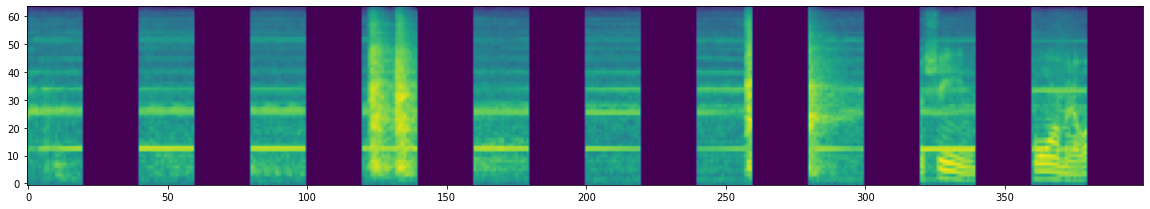

In [39]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [40]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.1399303911291382 0.8807002953695986 1.6666433113197832
 Average | 0.140 | 0.881 | 1.667 
---------+-------+-------+-------
       0 | 0.643 | 0.867 | 1.573 
       1 | 0.018 | 0.793 | 1.156 
       2 | 0.048 | 0.931 | 2.101 
       3 | 0.235 | 0.931 | 2.102 
       4 | 0.064 | 0.932 | 2.106 
       5 | 0.062 | 0.936 | 2.156 
       6 | 0.235 | 0.975 | 2.784 
       7 | 0.235 | 0.978 | 2.838 
       8 | 0.031 | 0.849 | 1.457 
       9 | 0.019 | 0.807 | 1.224 
      10 | 0.052 | 0.882 | 1.679 
      11 | 0.013 | 0.813 | 1.256 
      12 | 0.420 | 0.975 | 2.779 
      13 | 0.127 | 0.941 | 2.213 
      14 | 0.058 | 0.947 | 2.287 
      15 | 0.606 | 0.991 | 3.347 
      16 | 0.232 | 0.953 | 2.371 
      17 | 0.356 | 0.972 | 2.692 
      18 | 0.147 | 0.947 | 2.283 
      19 | 0.075 | 0.915 | 1.942 
      20 | 0.163 | 0.965 | 2.554 
      21 | 0.038 | 0

<h>Every 0.25s</h1>

In [41]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

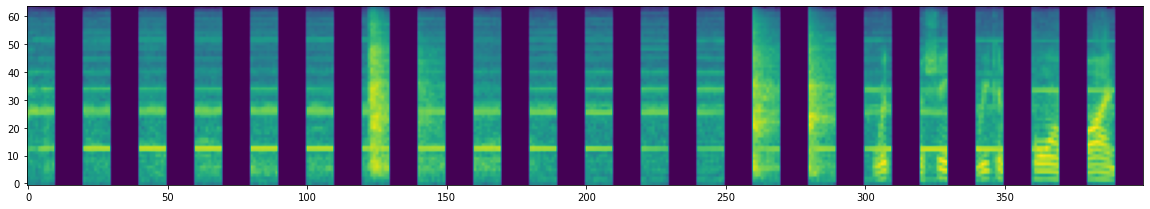

In [42]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [43]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.03257617229371128 0.7287065972060096 0.861122998426216
 Average | 0.033 | 0.729 | 0.861 
---------+-------+-------+-------
       0 | 0.544 | 0.796 | 1.171 
       1 | 0.009 | 0.661 | 0.586 
       2 | 0.020 | 0.855 | 1.497 
       3 | 0.094 | 0.880 | 1.663 
       4 | 0.047 | 0.901 | 1.824 
       5 | 0.023 | 0.855 | 1.498 
       6 | 0.070 | 0.948 | 2.297 
       7 | 0.027 | 0.853 | 1.481 
       8 | 0.009 | 0.598 | 0.350 
       9 | 0.004 | 0.586 | 0.306 
      10 | 0.011 | 0.700 | 0.742 
      11 | 0.003 | 0.460 |-0.143 
      12 | 0.005 | 0.682 | 0.670 
      13 | 0.004 | 0.588 | 0.314 
      14 | 0.018 | 0.816 | 1.275 
      15 | 0.405 | 0.952 | 2.347 
      16 | 0.040 | 0.866 | 1.565 
      17 | 0.036 | 0.895 | 1.777 
      18 | 0.030 | 0.894 | 1.768 
      19 | 0.016 | 0.822 | 1.303 
      20 | 0.028 | 0.886 | 1.702 
      21 | 0.015 | 0

<h>Every 0.125s</h1>

In [44]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

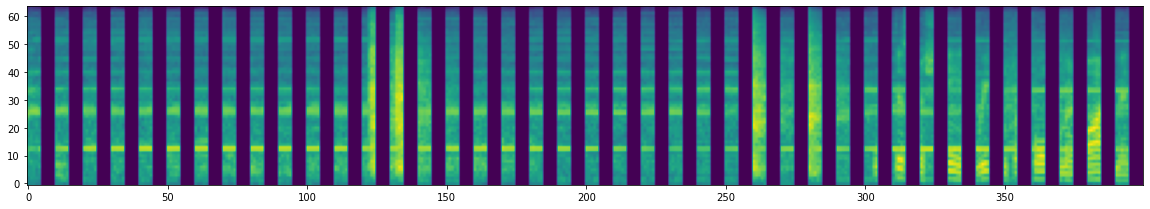

In [45]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [46]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.015277332243045021 0.634357341410147 0.4856639542624769
 Average | 0.015 | 0.634 | 0.486 
---------+-------+-------+-------
       0 | 0.454 | 0.703 | 0.753 
       1 | 0.005 | 0.613 | 0.405 
       2 | 0.009 | 0.725 | 0.845 
       3 | 0.072 | 0.827 | 1.334 
       4 | 0.011 | 0.770 | 1.046 
       5 | 0.009 | 0.516 | 0.056 
       6 | 0.019 | 0.828 | 1.337 
       7 | 0.005 | 0.577 | 0.275 
       8 | 0.003 | 0.534 | 0.120 
       9 | 0.005 | 0.509 | 0.030 
      10 | 0.009 | 0.698 | 0.733 
      11 | 0.003 | 0.466 |-0.120 
      12 | 0.005 | 0.725 | 0.845 
      13 | 0.003 | 0.529 | 0.104 
      14 | 0.017 | 0.803 | 1.205 
      15 | 0.038 | 0.883 | 1.681 
      16 | 0.019 | 0.764 | 1.016 
      17 | 0.009 | 0.773 | 1.060 
      18 | 0.021 | 0.847 | 1.450 
      19 | 0.016 | 0.786 | 1.119 
      20 | 0.009 | 0.751 | 0.957 
      21 | 0.014 | 

<h>concat 0.125s</h>

In [47]:
new_gas_eval = []
time_frame = 400
step = 5
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

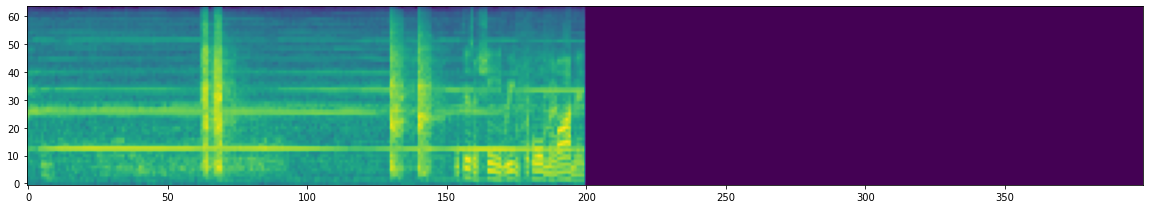

In [48]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [49]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.28142545855718176 0.9408625009470909 2.209079573429417
 Average | 0.281 | 0.941 | 2.209 
---------+-------+-------+-------
       0 | 0.675 | 0.892 | 1.748 
       1 | 0.042 | 0.858 | 1.515 
       2 | 0.079 | 0.933 | 2.120 
       3 | 0.265 | 0.955 | 2.396 
       4 | 0.122 | 0.968 | 2.610 
       5 | 0.024 | 0.908 | 1.876 
       6 | 0.231 | 0.981 | 2.949 
       7 | 0.340 | 0.978 | 2.853 
       8 | 0.119 | 0.922 | 2.009 
       9 | 0.062 | 0.921 | 1.994 
      10 | 0.118 | 0.951 | 2.345 
      11 | 0.111 | 0.964 | 2.537 
      12 | 0.653 | 0.996 | 3.748 
      13 | 0.276 | 0.988 | 3.187 
      14 | 0.158 | 0.963 | 2.519 
      15 | 0.715 | 0.995 | 3.665 
      16 | 0.332 | 0.970 | 2.661 
      17 | 0.360 | 0.984 | 3.020 
      18 | 0.113 | 0.954 | 2.385 
      19 | 0.138 | 0.946 | 2.267 
      20 | 0.304 | 0.968 | 2.629 
      21 | 0.134 | 0

<h>concat 0.25s</h>

In [50]:
new_gas_eval = []
time_frame = 400
step = 10
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

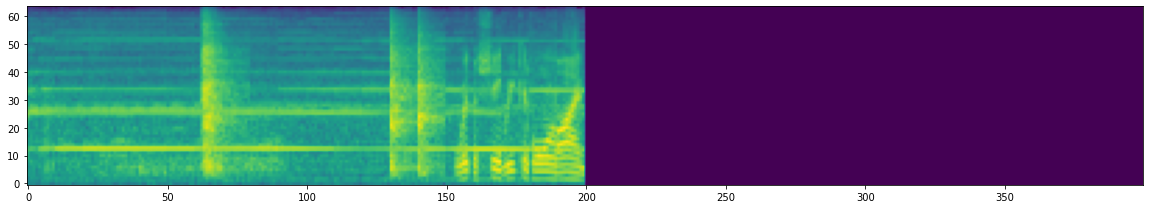

In [51]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [52]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.30504449498456315 0.9474590318128489 2.2920162979895595
 Average | 0.305 | 0.947 | 2.292 
---------+-------+-------+-------
       0 | 0.700 | 0.900 | 1.813 
       1 | 0.047 | 0.831 | 1.354 
       2 | 0.101 | 0.940 | 2.201 
       3 | 0.343 | 0.959 | 2.466 
       4 | 0.123 | 0.968 | 2.614 
       5 | 0.044 | 0.930 | 2.087 
       6 | 0.329 | 0.989 | 3.234 
       7 | 0.323 | 0.978 | 2.844 
       8 | 0.167 | 0.919 | 1.973 
       9 | 0.093 | 0.933 | 2.115 
      10 | 0.121 | 0.953 | 2.368 
      11 | 0.129 | 0.963 | 2.529 
      12 | 0.753 | 0.999 | 4.236 
      13 | 0.300 | 0.990 | 3.291 
      14 | 0.147 | 0.954 | 2.388 
      15 | 0.785 | 0.995 | 3.667 
      16 | 0.303 | 0.972 | 2.697 
      17 | 0.511 | 0.986 | 3.121 
      18 | 0.202 | 0.975 | 2.763 
      19 | 0.131 | 0.961 | 2.490 
      20 | 0.349 | 0.974 | 2.742 
      21 | 0.203 | 

<h>concat 0.5s</h>

In [53]:
new_gas_eval = []
time_frame = 400
step = 20
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

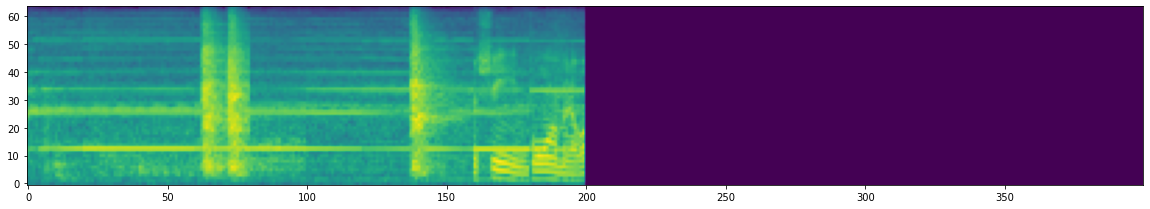

In [54]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [55]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3255812866481756 0.9508820561477259 2.33835524189462
 Average | 0.326 | 0.951 | 2.338 
---------+-------+-------+-------
       0 | 0.713 | 0.903 | 1.835 
       1 | 0.045 | 0.820 | 1.294 
       2 | 0.094 | 0.937 | 2.162 
       3 | 0.367 | 0.954 | 2.378 
       4 | 0.125 | 0.961 | 2.488 
       5 | 0.066 | 0.934 | 2.126 
       6 | 0.326 | 0.989 | 3.236 
       7 | 0.384 | 0.985 | 3.057 
       8 | 0.131 | 0.932 | 2.114 
       9 | 0.106 | 0.927 | 2.055 
      10 | 0.116 | 0.955 | 2.392 
      11 | 0.128 | 0.956 | 2.417 
      12 | 0.745 | 0.998 | 4.174 
      13 | 0.330 | 0.991 | 3.321 
      14 | 0.165 | 0.972 | 2.698 
      15 | 0.759 | 0.998 | 4.011 
      16 | 0.331 | 0.976 | 2.801 
      17 | 0.401 | 0.988 | 3.171 
      18 | 0.203 | 0.973 | 2.721 
      19 | 0.170 | 0.959 | 2.465 
      20 | 0.319 | 0.987 | 3.130 
      21 | 0.127 | 0.9

<h>concat 1s</h>

In [56]:
new_gas_eval = []
time_frame = 400
step = 40
half = 200
n_mel = 64

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(time_frame):
        if i % step == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(half,n_mel)
    fill_matrix = numpy.full((half,n_mel), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

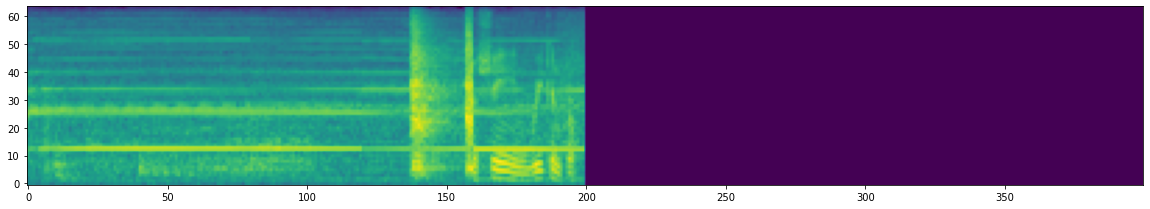

In [57]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [58]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
        output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.3334886580841985 0.9512719032189997 2.343794639271478
 Average | 0.333 | 0.951 | 2.344 
---------+-------+-------+-------
       0 | 0.724 | 0.903 | 1.841 
       1 | 0.051 | 0.824 | 1.319 
       2 | 0.087 | 0.920 | 1.987 
       3 | 0.340 | 0.955 | 2.402 
       4 | 0.189 | 0.963 | 2.523 
       5 | 0.054 | 0.924 | 2.029 
       6 | 0.388 | 0.983 | 2.987 
       7 | 0.342 | 0.976 | 2.801 
       8 | 0.185 | 0.932 | 2.109 
       9 | 0.091 | 0.927 | 2.058 
      10 | 0.113 | 0.954 | 2.381 
      11 | 0.179 | 0.957 | 2.425 
      12 | 0.758 | 0.999 | 4.302 
      13 | 0.349 | 0.992 | 3.377 
      14 | 0.216 | 0.953 | 2.368 
      15 | 0.766 | 0.996 | 3.755 
      16 | 0.389 | 0.978 | 2.862 
      17 | 0.546 | 0.989 | 3.256 
      18 | 0.170 | 0.967 | 2.599 
      19 | 0.199 | 0.968 | 2.628 
      20 | 0.321 | 0.974 | 2.750 
      21 | 0.140 | 0.

# White noise 2D

In [20]:
import numpy as np
new_gas_eval = []
for record in gas_eval_x1:
    record += np.random.normal(0, 0.1, (400,64))
    new_gas_eval.append(record)
new_gas_eval = numpy.array(new_gas_eval)

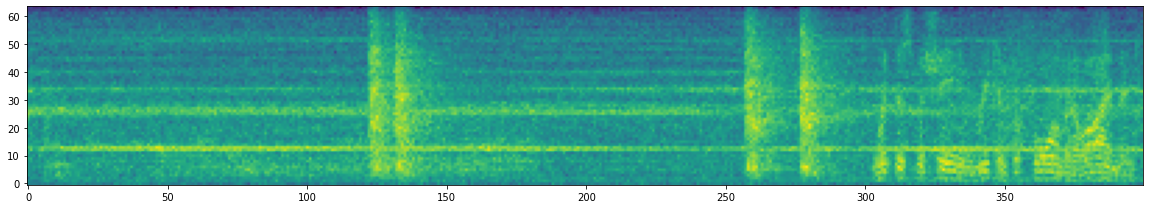

In [21]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')
plt.savefig('imgs/noise_hammer0.1.png')

In [22]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.055976838225604245 0.7267134118814932 0.8526336926864674
 Average | 0.056 | 0.727 | 0.853 
---------+-------+-------+-------
       0 | 0.594 | 0.831 | 1.354 
       1 | 0.010 | 0.763 | 1.011 
       2 | 0.038 | 0.889 | 1.724 
       3 | 0.164 | 0.895 | 1.775 
       4 | 0.175 | 0.954 | 2.384 
       5 | 0.066 | 0.917 | 1.963 
       6 | 0.127 | 0.923 | 2.014 
       7 | 0.242 | 0.959 | 2.462 
       8 | 0.012 | 0.767 | 1.030 
       9 | 0.009 | 0.708 | 0.775 
      10 | 0.019 | 0.813 | 1.257 
      11 | 0.007 | 0.712 | 0.793 
      12 | 0.012 | 0.823 | 1.310 
      13 | 0.014 | 0.848 | 1.456 
      14 | 0.086 | 0.897 | 1.790 
      15 | 0.133 | 0.880 | 1.663 
      16 | 0.202 | 0.917 | 1.959 
      17 | 0.209 | 0.972 | 2.710 
      18 | 0.068 | 0.937 | 2.163 
      19 | 0.075 | 0.882 | 1.675 
      20 | 0.227 | 0.963 | 2.518 
      21 | 0.057 |

# Adversarial Perturbation

In [50]:
from torch.cuda.amp import autocast,GradScaler

In [51]:
import numpy as np
np.unique(gas_eval_y.astype('float16'))
print(np.min(gas_eval_x1), np.max(gas_eval_x1))

-2.0821576 1.3378971


In [52]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(gas_eval_x1[:]), torch.from_numpy(gas_eval_y[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=75, shuffle=True)

In [53]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, delta_min, delta_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCELoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
           
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)

            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()

            #######   get gradient #################
#             with torch.no_grad():
#             model.train()# double check

            out = model(_x_adv_1)
#                 print(out)
#                 out = torch.sigmoid(out)
#                 epsilon = 1e-7
#                 out = torch.clamp(out, epsilon, 1. - epsilon)
#                 temp_out = out.clamp(0,1).cuda()
#                 print(temp_out.shape, y.shape, temp_out.max(), temp_out.min())
#                 print(temp_out.shape, y.shape)

            loss = criterion(out, y.to('cuda', non_blocking=True))
            loss_global += loss.item()
#                 print(loss.item(), loss_global)
            loss.backward()
#             break
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
#             print(delta)
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
#             print(scaling_factor)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / (scaling_factor+1e-7).view(-1, T_1, 1)
#             print(delta)
#             return delta
            delta = delta.float()
            delta = torch.mean(delta,0)
#             print(delta)
            delta_global += delta * N_1 / 20123
            delta_global = delta_global.clamp(delta_min, delta_max)
#             print(delta_global)
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [54]:
# np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0), np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)

In [55]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm='inf', eps= 0.1, eps_norm='inf', x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1), delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:3.7489089453592896
global loss:3.7477889489382505
global loss:3.752655482850969
global loss:3.7587920976802707
global loss:3.7812849851325154
global loss:3.855769654735923
global loss:4.658028040081263
global loss:6.763662002980709
global loss:7.714704588055611
global loss:7.906905110925436
global loss:7.933343825861812
global loss:7.961155107244849
global loss:7.943079957738519
global loss:7.86566580273211
global loss:7.7579356264323
global loss:7.643488196656108
global loss:7.542623599991202
global loss:7.450992593541741
global loss:7.372867874801159
global loss:7.309371726587415


In [56]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

In [57]:
print(np.min(new_gas_eval), np.max(new_gas_eval))

-2.0821576 1.3378971


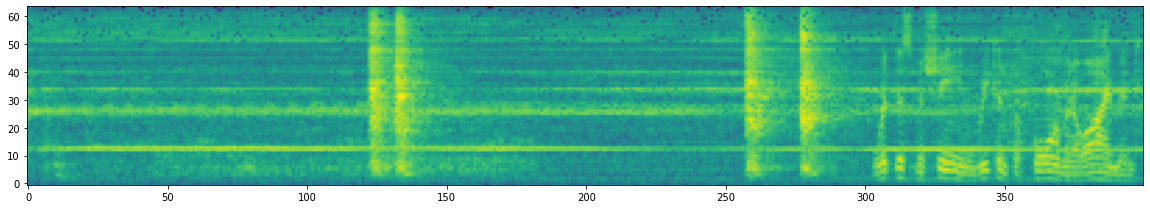

In [58]:

plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')

In [59]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.16389298791284876 0.8905389616389623 1.7386333744692921
 Average | 0.164 | 0.891 | 1.739 
---------+-------+-------+-------
       0 | 0.654 | 0.876 | 1.631 
       1 | 0.036 | 0.810 | 1.244 
       2 | 0.050 | 0.915 | 1.937 
       3 | 0.282 | 0.936 | 2.147 
       4 | 0.119 | 0.936 | 2.152 
       5 | 0.072 | 0.930 | 2.085 
       6 | 0.340 | 0.978 | 2.840 
       7 | 0.300 | 0.960 | 2.482 
       8 | 0.046 | 0.864 | 1.551 
       9 | 0.032 | 0.810 | 1.244 
      10 | 0.068 | 0.873 | 1.614 
      11 | 0.029 | 0.874 | 1.619 
      12 | 0.613 | 0.994 | 3.521 
      13 | 0.189 | 0.966 | 2.577 
      14 | 0.177 | 0.960 | 2.475 
      15 | 0.550 | 0.965 | 2.559 
      16 | 0.315 | 0.968 | 2.626 
      17 | 0.404 | 0.993 | 3.469 
      18 | 0.133 | 0.966 | 2.589 
      19 | 0.174 | 0.959 | 2.459 
      20 | 0.300 | 0.984 | 3.015 
      21 | 0.141 | 

## l_2 norm attack

In [60]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.01, step_norm=2, eps= 0.1, eps_norm=2, x_min=np.min(gas_eval_x1), x_max=np.max(gas_eval_x1),delta_min = torch.tensor(np.min(gas_eval_x1) - np.min(gas_eval_x1,axis=0)).cuda(), delta_max = torch.tensor(np.max(gas_eval_x1) - np.max(gas_eval_x1,axis=0)).cuda(), y_target=None )

global loss:3.750323001295328
global loss:3.8100682199001312
global loss:3.9216707767918706
global loss:4.16820970363915
global loss:4.560555460862815
global loss:5.078445411287248
global loss:5.60597326233983
global loss:6.094974596053362
global loss:6.485265623778105
global loss:6.7863327115774155
global loss:7.017049008980393
global loss:7.192522032186389
global loss:7.335526084527373
global loss:7.4394361060112715
global loss:7.526097333058715
global loss:7.598338613286614
global loss:7.656536808237433
global loss:7.693053295835853
global loss:7.722237726673484
global loss:7.746574476361275


In [61]:
new_gas_eval = perturb.cpu().numpy() + gas_eval_x1

In [62]:
result = []
batch_size =100
x = new_gas_eval 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

total num of batches during testing 202
Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.11677629188663431 0.8558676064847948 1.501804148865458
 Average | 0.117 | 0.856 | 1.502 
---------+-------+-------+-------
       0 | 0.629 | 0.871 | 1.600 
       1 | 0.048 | 0.806 | 1.219 
       2 | 0.038 | 0.912 | 1.910 
       3 | 0.186 | 0.929 | 2.073 
       4 | 0.081 | 0.951 | 2.335 
       5 | 0.028 | 0.875 | 1.630 
       6 | 0.178 | 0.946 | 2.269 
       7 | 0.189 | 0.930 | 2.082 
       8 | 0.025 | 0.821 | 1.298 
       9 | 0.011 | 0.765 | 1.024 
      10 | 0.048 | 0.902 | 1.832 
      11 | 0.013 | 0.819 | 1.289 
      12 | 0.211 | 0.949 | 2.307 
      13 | 0.071 | 0.943 | 2.232 
      14 | 0.097 | 0.946 | 2.269 
      15 | 0.145 | 0.781 | 1.097 
      16 | 0.285 | 0.943 | 2.238 
      17 | 0.280 | 0.977 | 2.826 
      18 | 0.136 | 0.963 | 2.532 
      19 | 0.088 | 0.926 | 2.049 
      20 | 0.194 | 0.974 | 2.742 
      21 | 0.069 | 0

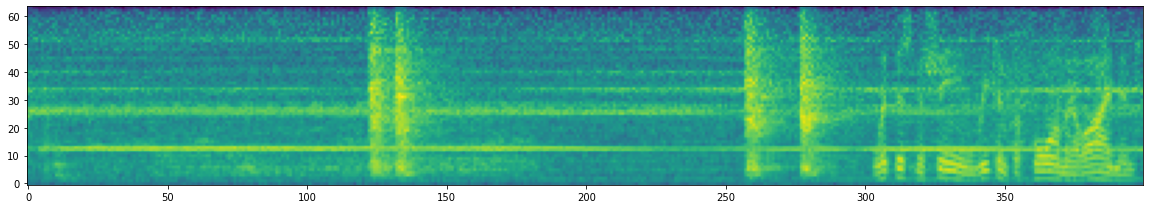

In [64]:
plt.figure(figsize = (20,10))
plt.imshow(new_gas_eval[1].T, origin='lower')
plt.savefig('imgs/hammer_adv_l2_e0.1_step20.png')

# Strong Label Masking

In [37]:
hf_val_eval_path = os.path.join(local, 'data_64_400_strong_corrected.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

strong_gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

In [38]:
result = []
batch_size =100
x = strong_gas_eval_x1 
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [39]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.19365913407736685 0.7916667513900515 1.148649848177568
 Average | 0.194 | 0.792 | 1.149 
---------+-------+-------+-------
       0 | 0.580 | 0.760 | 0.997 
       1 | 0.012 | 0.616 | 0.418 
       2 | 0.012 | 0.736 | 0.891 
       3 | 0.186 | 0.788 | 1.132 
       4 | 0.074 | 0.676 | 0.645 
       5 | 0.042 | 0.780 | 1.091 
       6 | 0.203 | 0.905 | 1.856 
       7 | 0.145 | 0.879 | 1.652 
       8 | 0.052 | 0.788 | 1.132 
       9 | 0.026 | 0.808 | 1.233 
      10 | 0.128 | 0.760 | 0.999 
      11 | 0.062 | 0.751 | 0.956 
      12 | 0.213 | 0.650 | 0.544 
      13 | 0.061 | 0.775 | 1.066 
      14 | 0.141 | 0.908 | 1.883 
      15 | 0.364 | 0.908 | 1.879 
      16 | 0.210 | 0.884 | 1.692 
      17 | 0.259 | 0.933 | 2.121 
      18 | 0.146 | 0.896 | 1.781 
      19 | 0.175 | 0.933 | 2.114 
      20 | 0.261 | 0.857 | 1.510 
      21 | 0.091 | 0.885 | 1.700 
      22 | 0.361 | 0.902 |

# Gaussian Noise Correct from WAV

In [40]:
hf_val_eval_path = os.path.join(local, 'data_64_400_noise0.1.h5')
mu_val=args.mean
sigma_val=args.std
                            
def bulk_load2(file_path, mu, sigma):
    hf_val_eval = h5py.File(file_path, 'r')
    feat_a = (hf_val_eval['feat_a'][:]*2-mu)/(2 * sigma)
    labels = hf_val_eval['labels'][:]
    hf_val_eval.close()
    return feat_a.astype('float32'), labels.astype('bool')

noisy_gas_eval_x1, gas_eval_y = bulk_load2(hf_val_eval_path, mu_val, sigma_val)

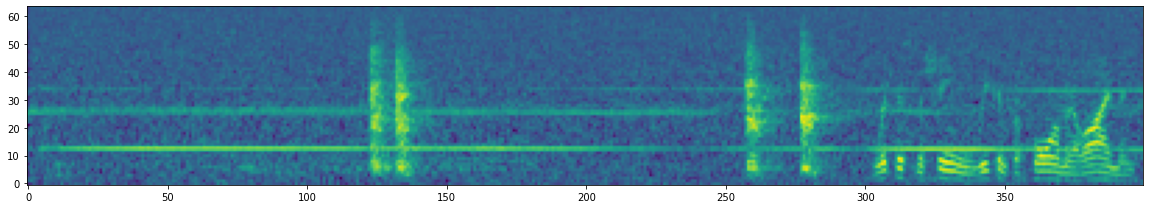

In [41]:
plt.figure(figsize = (20,10))
plt.imshow(noisy_gas_eval_x1[1].T, origin='lower')
plt.savefig('imgs/1dnoise0.1_hammer.png')

In [42]:
result = []
batch_size =100
x = noisy_gas_eval_x1
# x = new_gas_eval
# x = gas_eval_x1_origin
for i in range(0, len(x), batch_size):
    with torch.no_grad():
        input = Variable(torch.from_numpy(x[i : i + batch_size])).cuda()
        output = model.forward(input)
#                 print(output)
#         output = torch.sigmoid(output)
#                 print(f'output shape: {output.shape}')
#                 print(output)
        result.append([output.data.cpu().numpy()])
print('total num of batches during testing', len(result))
result = [numpy.concatenate(items) for items in zip(*result)]

total num of batches during testing 202


In [43]:
gas_eval_global_prob_multi = result[0]
print('Performance on Google Audio Set:')
print("   CLASS |    AP |   AUC |    d' ")
FORMAT  = ' %00007s | %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

Performance on Google Audio Set:
   CLASS |    AP |   AUC |    d' 
---------+-------+-------+-------
0.15502703854631983 0.8274027310864701 1.3349487234195736
 Average | 0.155 | 0.827 | 1.335 
---------+-------+-------+-------
       0 | 0.632 | 0.849 | 1.460 
       1 | 0.049 | 0.789 | 1.136 
       2 | 0.035 | 0.864 | 1.550 
       3 | 0.266 | 0.929 | 2.072 
       4 | 0.051 | 0.920 | 1.984 
       5 | 0.023 | 0.872 | 1.604 
       6 | 0.106 | 0.921 | 1.993 
       7 | 0.174 | 0.929 | 2.077 
       8 | 0.120 | 0.890 | 1.732 
       9 | 0.072 | 0.877 | 1.638 
      10 | 0.112 | 0.951 | 2.346 
      11 | 0.123 | 0.954 | 2.384 
      12 | 0.607 | 0.986 | 3.126 
      13 | 0.357 | 0.992 | 3.409 
      14 | 0.121 | 0.939 | 2.188 
      15 | 0.003 | 0.506 | 0.020 
      16 | 0.311 | 0.931 | 2.100 
      17 | 0.418 | 0.963 | 2.519 
      18 | 0.075 | 0.938 | 2.170 
      19 | 0.128 | 0.908 | 1.881 
      20 | 0.165 | 0.959 | 2.464 
      21 | 0.043 | 0.847 | 1.448 
      22 | 0.182 | 0.850 